## Predictive Modeling with PyCaret
*for Health Insurance Cross Sell Prediction project*

#### Load Packages

In [1]:
import pandas as pd
import requests
from io import StringIO
from pycaret.classification import *
import matplotlib as mpl
import matplotlib.pyplot as plt

#### Load Data

In [2]:
# Download train.csv data from GitHub
url = "https://raw.githubusercontent.com/ssears219/Health-Insurance-Cross-Sell-Prediction/main/Data/Kaggle%20Data/train.csv"
file = requests.get(url).content

# Read to pandas df
data = pd.read_csv(StringIO(file.decode('utf-8')))

In [3]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


### Data Preparation with PyCaret

In [4]:
clf = setup(data, target='Response', session_id=123, log_experiment=True, experiment_name='HICS')

,Description,Value
0,session_id,123
1,Target,Response
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(381109, 12)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


### Modeling with PyCaret

In [5]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8772,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1190
ada,Ada Boost Classifier,0.8772,0.8516,0.0003,0.2936,0.0006,0.0004,0.0062,4.6750
gbc,Gradient Boosting Classifier,0.8772,0.8555,0.0001,0.3333,0.0002,0.0002,0.0047,17.5630
lightgbm,Light Gradient Boosting Machine,0.8769,0.8569,0.0030,0.3636,0.0060,0.0040,0.0233,1.6380
lda,Linear Discriminant Analysis,0.8768,0.8338,0.0027,0.3305,0.0053,0.0033,0.0198,0.4360
lr,Logistic Regression,0.8728,0.7329,0.0352,0.1974,0.0592,0.0389,0.0560,3.6290
rf,Random Forest Classifier,0.8663,0.8342,0.1201,0.3652,0.1807,0.1277,0.1515,16.0670
et,Extra Trees Classifier,0.8621,0.8268,0.1448,0.3514,0.2051,0.1437,0.1608,13.4850
knn,K Neighbors Classifier,0.8586,0.5955,0.0550,0.2109,0.0872,0.0383,0.0488,10.4370
svm,SVM - Linear Kernel,0.8380,0.0000,0.0782,0.1101,0.0485,0.0108,0.0144,5.6850


In [6]:
lightgbm = create_model('lightgbm', fold=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8769,0.8555,0.0024,0.3333,0.0048,0.0031,0.0192
1,0.8768,0.8570,0.0027,0.3333,0.0054,0.0034,0.0204
2,0.8770,0.8604,0.0024,0.4000,0.0049,0.0034,0.0231
3,0.8769,0.8548,0.0043,0.4118,0.0085,0.0059,0.0314
4,0.8770,0.8567,0.0031,0.4000,0.0061,0.0042,0.0259
5,0.8764,0.8558,0.0031,0.2439,0.0060,0.0030,0.0145
6,0.8768,0.8556,0.0024,0.3077,0.0048,0.0029,0.0176
7,0.8769,0.8589,0.0012,0.2500,0.0024,0.0012,0.0095
8,0.8773,0.8588,0.0052,0.5484,0.0103,0.0080,0.0442
9,0.8770,0.8557,0.0034,0.4074,0.0067,0.0047,0.0276


In [7]:
tuned_lightgbm = tune_model(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8771,0.8554,0.0000,0.0000,0.0000,-0.0001,-0.0032
1,0.8772,0.8567,0.0006,1.0000,0.0012,0.0011,0.0231
2,0.8771,0.8606,0.0003,0.2000,0.0006,0.0002,0.0032
3,0.8772,0.8542,0.0027,0.5000,0.0055,0.0041,0.0299
4,0.8771,0.8559,0.0021,0.4667,0.0043,0.0031,0.0248
5,0.8772,0.8554,0.0012,0.5714,0.0024,0.0019,0.0221
6,0.8772,0.8556,0.0006,0.6667,0.0012,0.0010,0.0176
7,0.8773,0.8574,0.0012,0.8000,0.0024,0.0021,0.0283
8,0.8772,0.8586,0.0003,0.5000,0.0006,0.0005,0.0100
9,0.8773,0.8557,0.0012,0.8000,0.0024,0.0021,0.0283


In [31]:
predictions = predict_model(tuned_lightgbm, raw_score=True, probability_threshold=0.1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6731,0.8573,0.9610,0.2667,0.4176,0.2801,0.3917


In [27]:
predictions

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Gender_Male,Driving_License_1,Previously_Insured_0,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes,Response,Label,Score_0,Score_1
0,22.0,46.0,2630.0,160.0,267.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0,0,0.9453,0.0547
1,27.0,41.0,2630.0,160.0,275.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0,0,0.9930,0.0070
2,46.0,28.0,32816.0,124.0,138.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0.9987,0.0013
3,25.0,29.0,41936.0,152.0,34.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0,0,0.9993,0.0007
4,21.0,30.0,33446.0,152.0,295.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0,0,0.9028,0.0972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114328,42.0,28.0,28609.0,124.0,64.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,0.9580,0.0420
114329,62.0,28.0,65932.0,13.0,210.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0.9994,0.0006
114330,48.0,6.0,22611.0,26.0,288.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0,0,0.6365,0.3635
114331,67.0,50.0,34190.0,8.0,152.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0.9995,0.0005


### Customer Segmentation Using the Model

In [29]:
comp_df = pd.DataFrame({'Actual': predictions['Response'].astype(float), 'Predicted': predictions['Score_1']})

bounds = []
interval_totals = []
interested_totals = []
for bound in range(0,91,10):
    upper = (bound+10)/100
    lower = bound/100
    interval = predictions[(predictions['Score_1'] >= lower) & (predictions['Score_1'] < upper)]
    bounds.append('{:.1f}-{:.1f}'.format(lower, upper))
    interested_totals.append(interval[interval['Response'] == '1'].shape[0])
    interval_totals.append(interval.shape[0])
    
comp_plot_df = pd.DataFrame({'Probability': bounds, 'Interval Total': interval_totals, 'Interested': interested_totals})
comp_plot_df['Not Interested'] = comp_plot_df['Interval Total'] - comp_plot_df['Interested']
comp_plot_df

,Probability,Interval Total,Interested,Not Interested
0,0.0-0.1,64094,544,63550
1,0.1-0.2,14202,2059,12143
2,0.2-0.3,15384,3910,11474
3,0.3-0.4,17718,6123,11595
4,0.4-0.5,2921,1302,1619
5,0.5-0.6,14,6,8
6,0.6-0.7,0,0,0
7,0.7-0.8,0,0,0
8,0.8-0.9,0,0,0
9,0.9-1.0,0,0,0


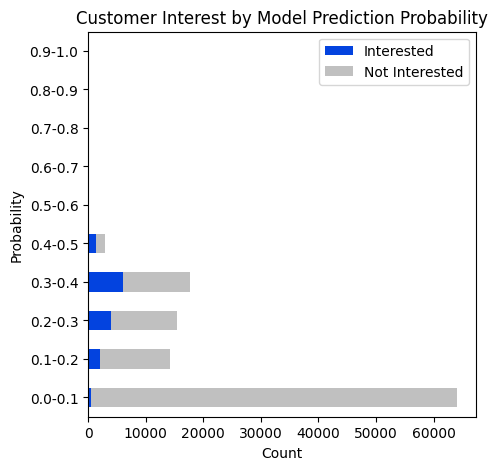

In [30]:
chart_df = comp_plot_df[['Probability', 'Interested', 'Not Interested']].set_index('Probability')

ax = chart_df.plot(kind='barh',
                   stacked=True,
                   label="Series",
                   color=['#0343DF','#C0C0C0'],
                   figsize=(5,5))

ax.set_xlabel('Count')
ax.set_ylabel('Probability')
ax.set_title('Customer Interest by Model Prediction Probability')
ax.legend(loc=1,
          labels = ['Interested', 'Not Interested'])

plt.show()